In [ ]:
!pip install --upgrade scikit-learn imbalanced-learn


In [1]:
import sklearn
import imblearn
import pickle

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from imblearn.over_sampling import SMOTE


In [2]:
df = pd.read_csv('data/bank-additional-full.csv', sep=';')
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [4]:
pd.DataFrame(df.describe(include = [object]))


,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563,36548


In [5]:
print(f"Dataset shape: {df.shape}")


Dataset shape: (41188, 21)


In [6]:
print("\nData types:\n", df.dtypes.value_counts())



Data types:
 object     11
int64       5
float64     5
Name: count, dtype: int64


In [7]:
print("\nMissing values:\n", df.isnull().sum())



Missing values:
 age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


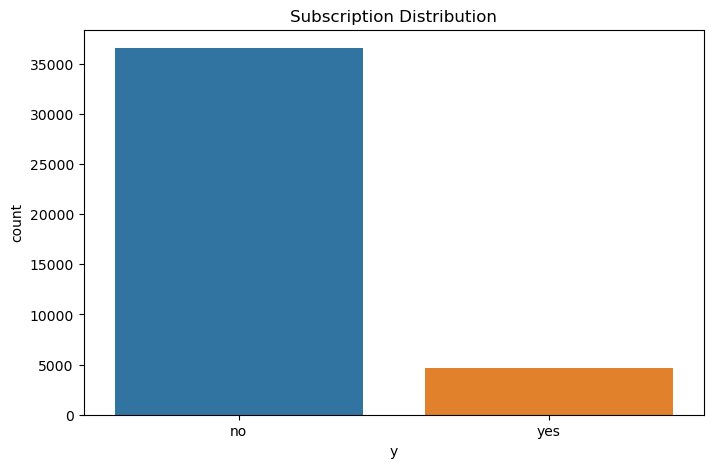

In [8]:
# Target variable distribution
plt.figure(figsize=(8,5))
sns.countplot(x='y', data=df)
plt.title('Subscription Distribution')
plt.show()


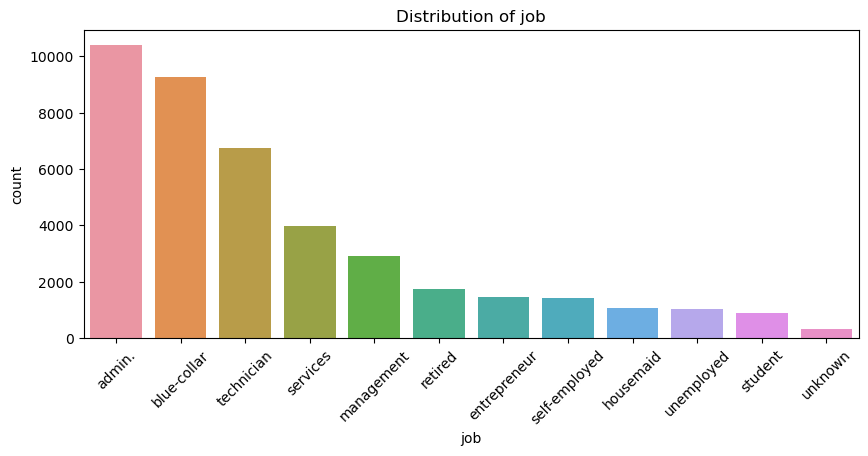

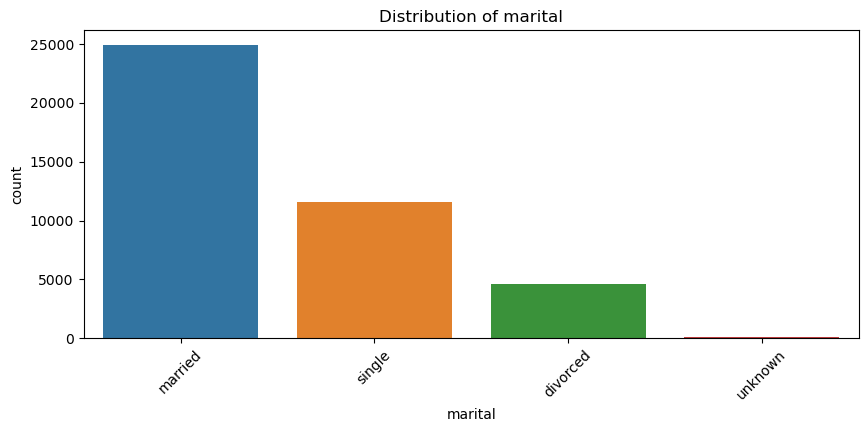

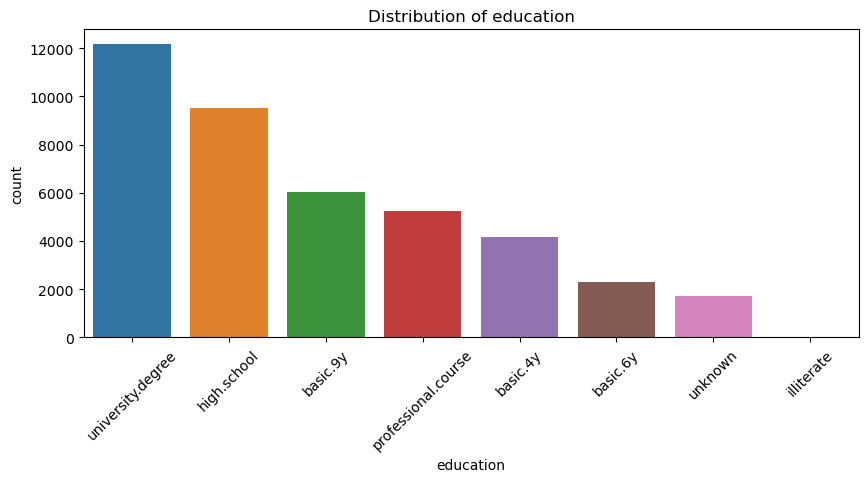

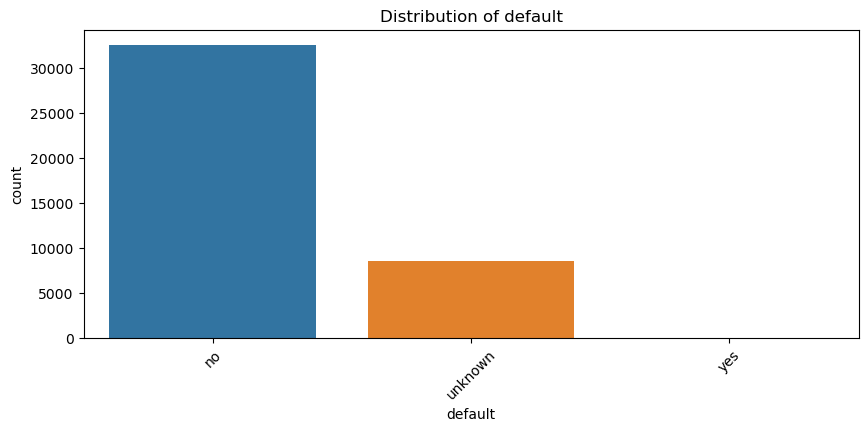

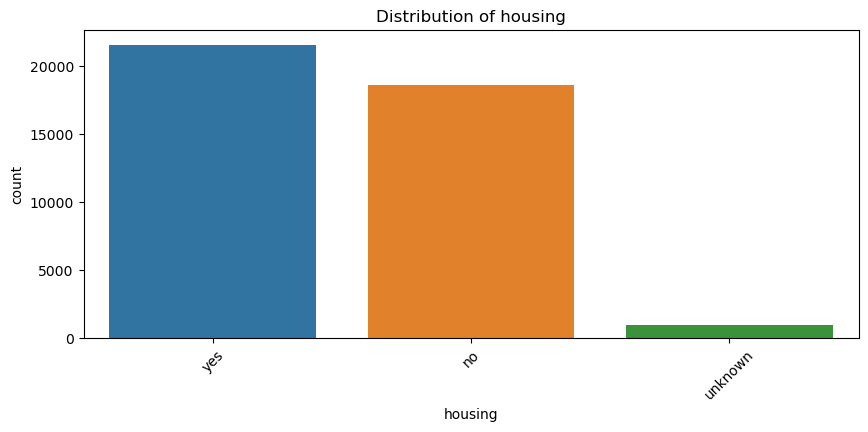

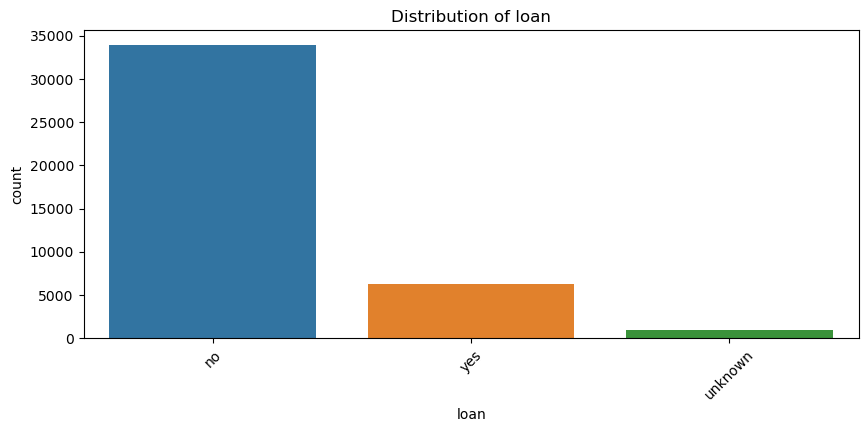

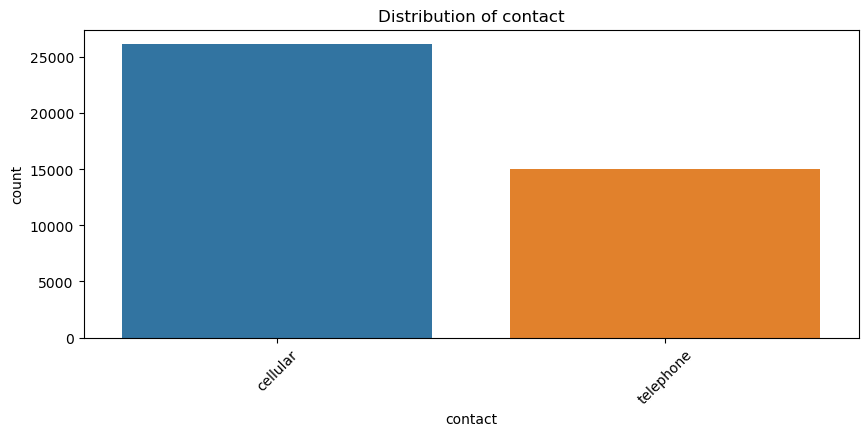

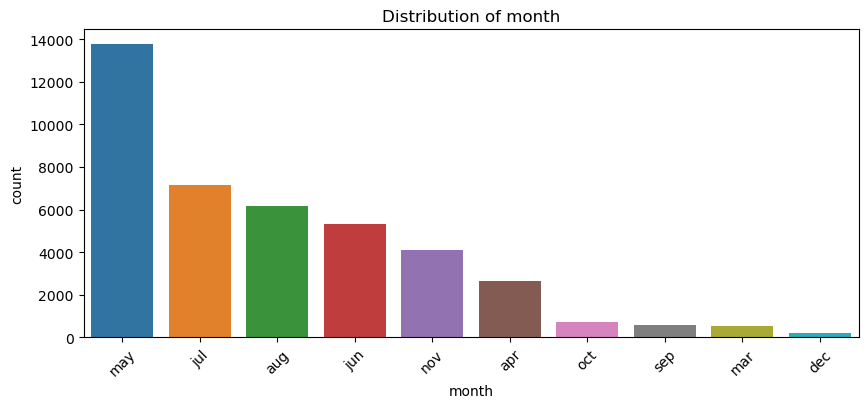

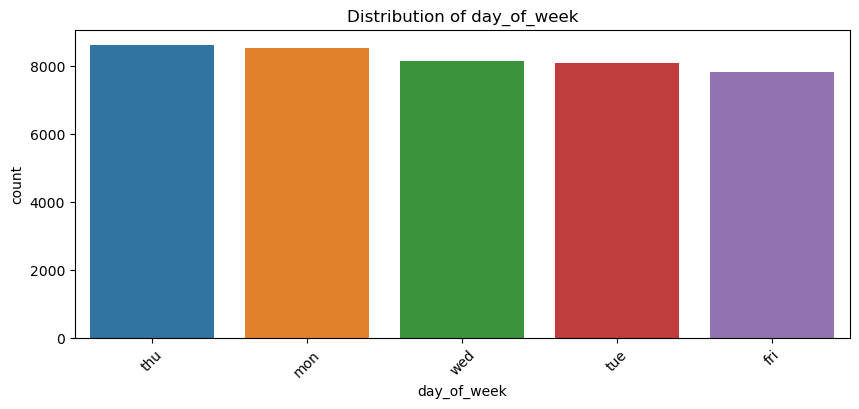

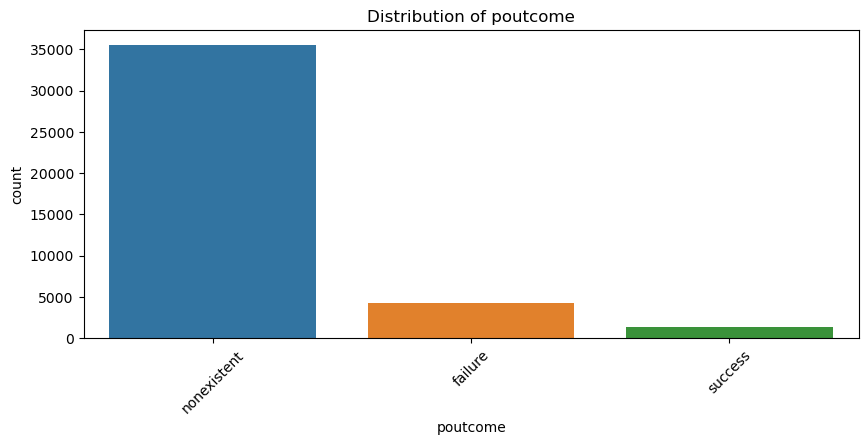

In [9]:
categorical_cols = df.select_dtypes(include='object').columns.tolist()
categorical_cols.remove('y')

for col in categorical_cols:
    plt.figure(figsize=(10, 4))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.xticks(rotation=45)
    plt.title(f'Distribution of {col}')
    plt.show()


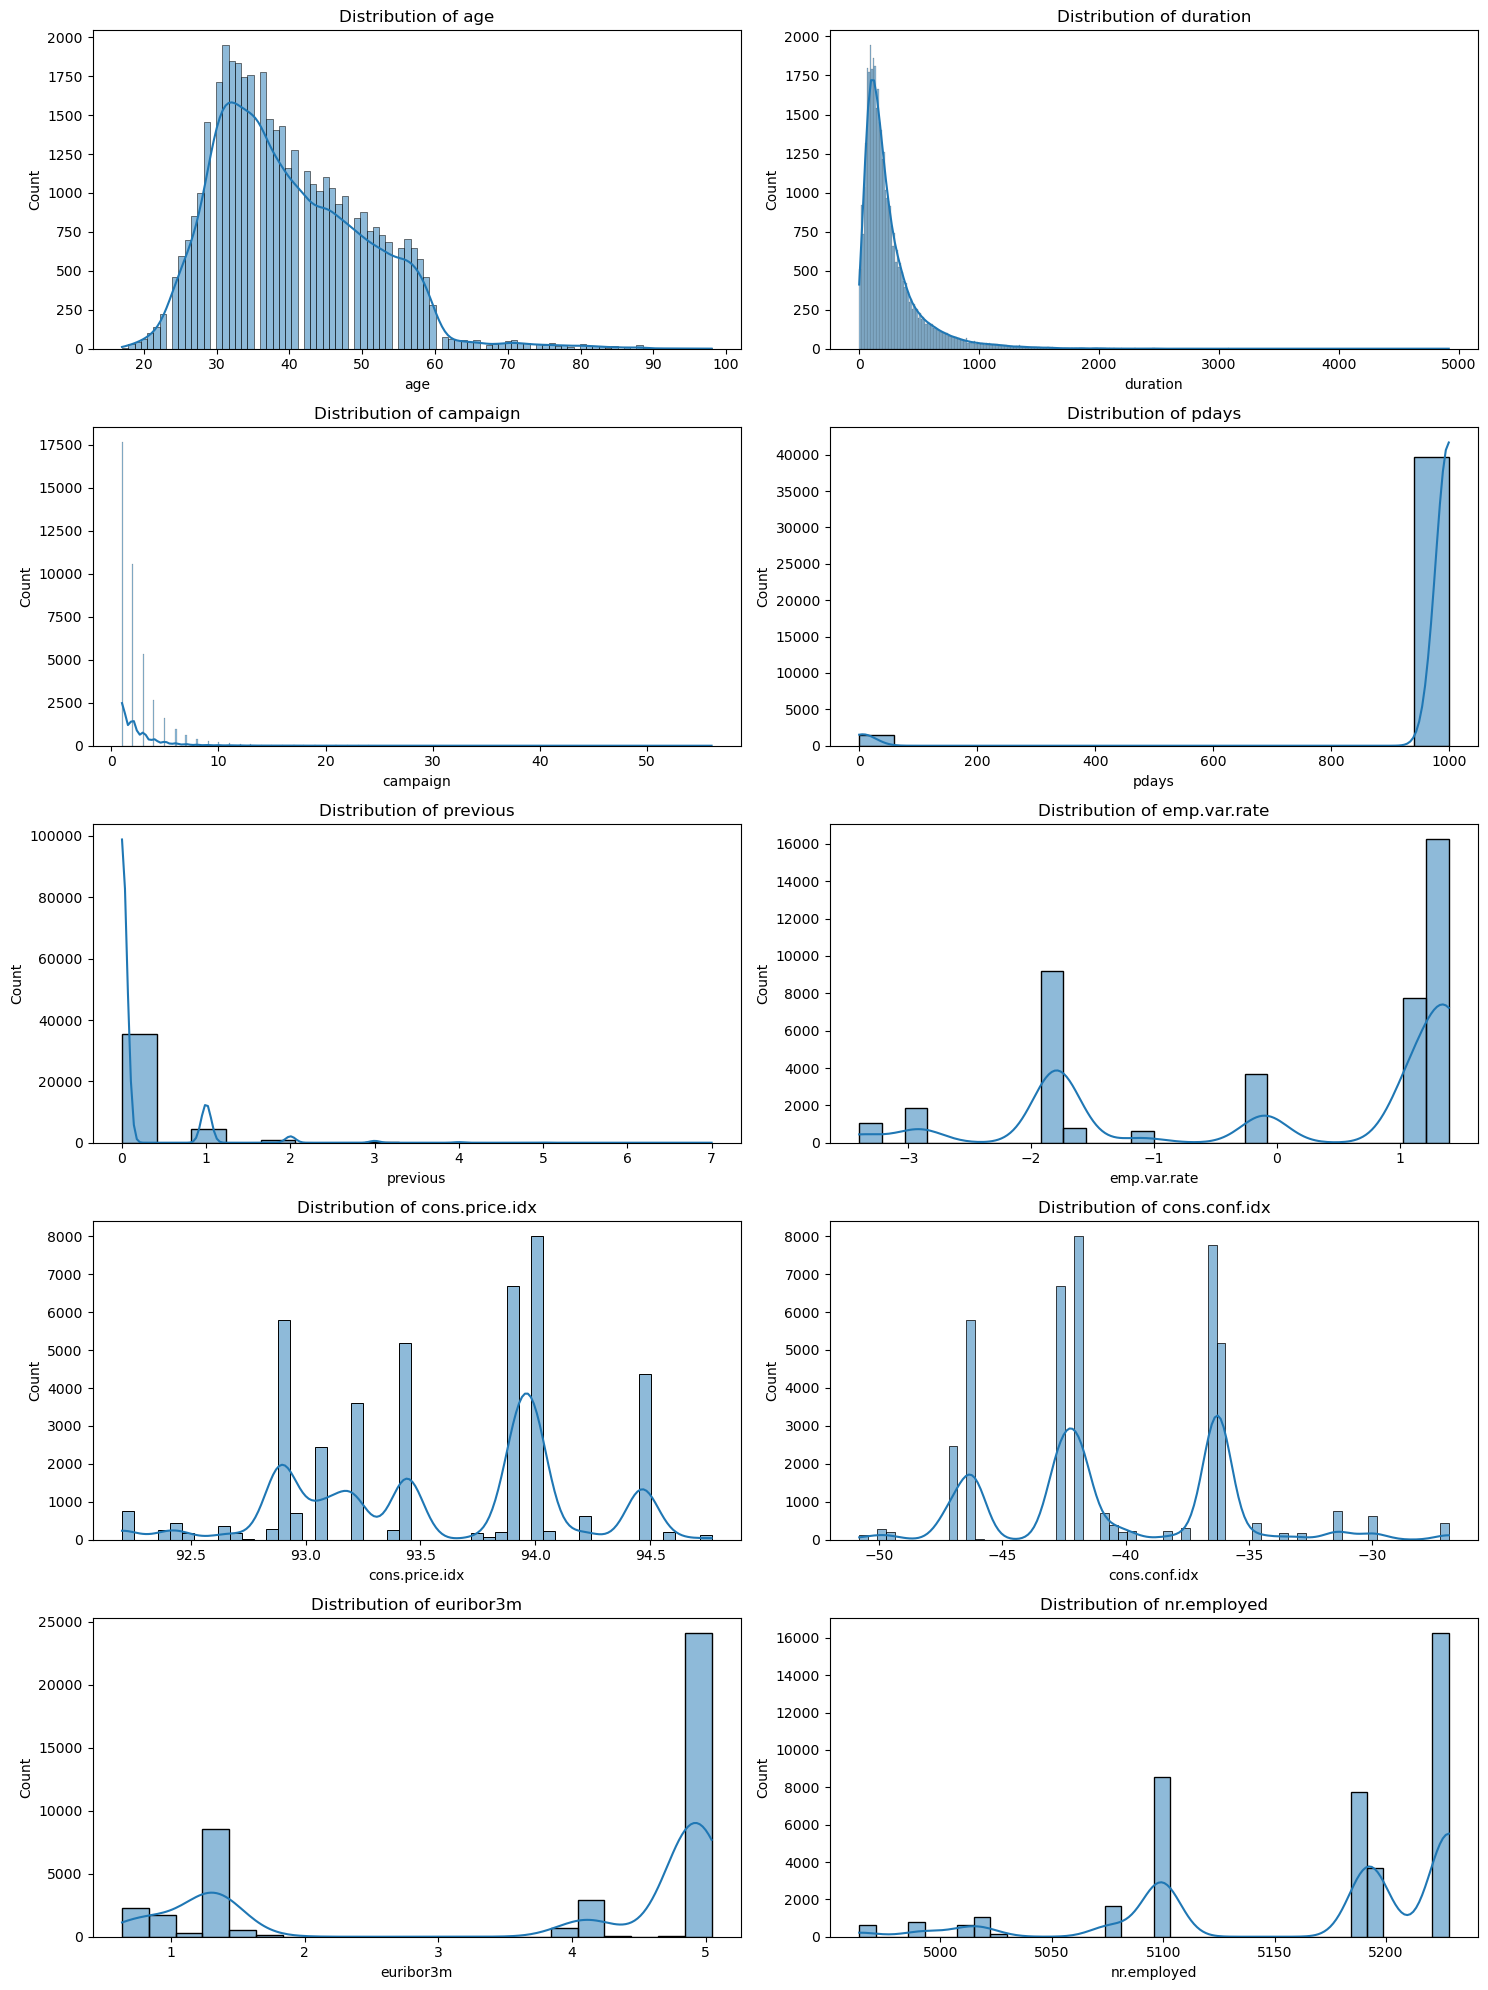

In [11]:
# Numerical features
num_cols = ['age', 'duration', 'campaign', 'pdays', 'previous', 
            'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

fig, axes = plt.subplots(5, 2, figsize=(15, 20))
for i, col in enumerate(num_cols):
    row, col_idx = i//2, i%2
    sns.histplot(df[col], kde=True, ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'Distribution of {col}')
plt.tight_layout()


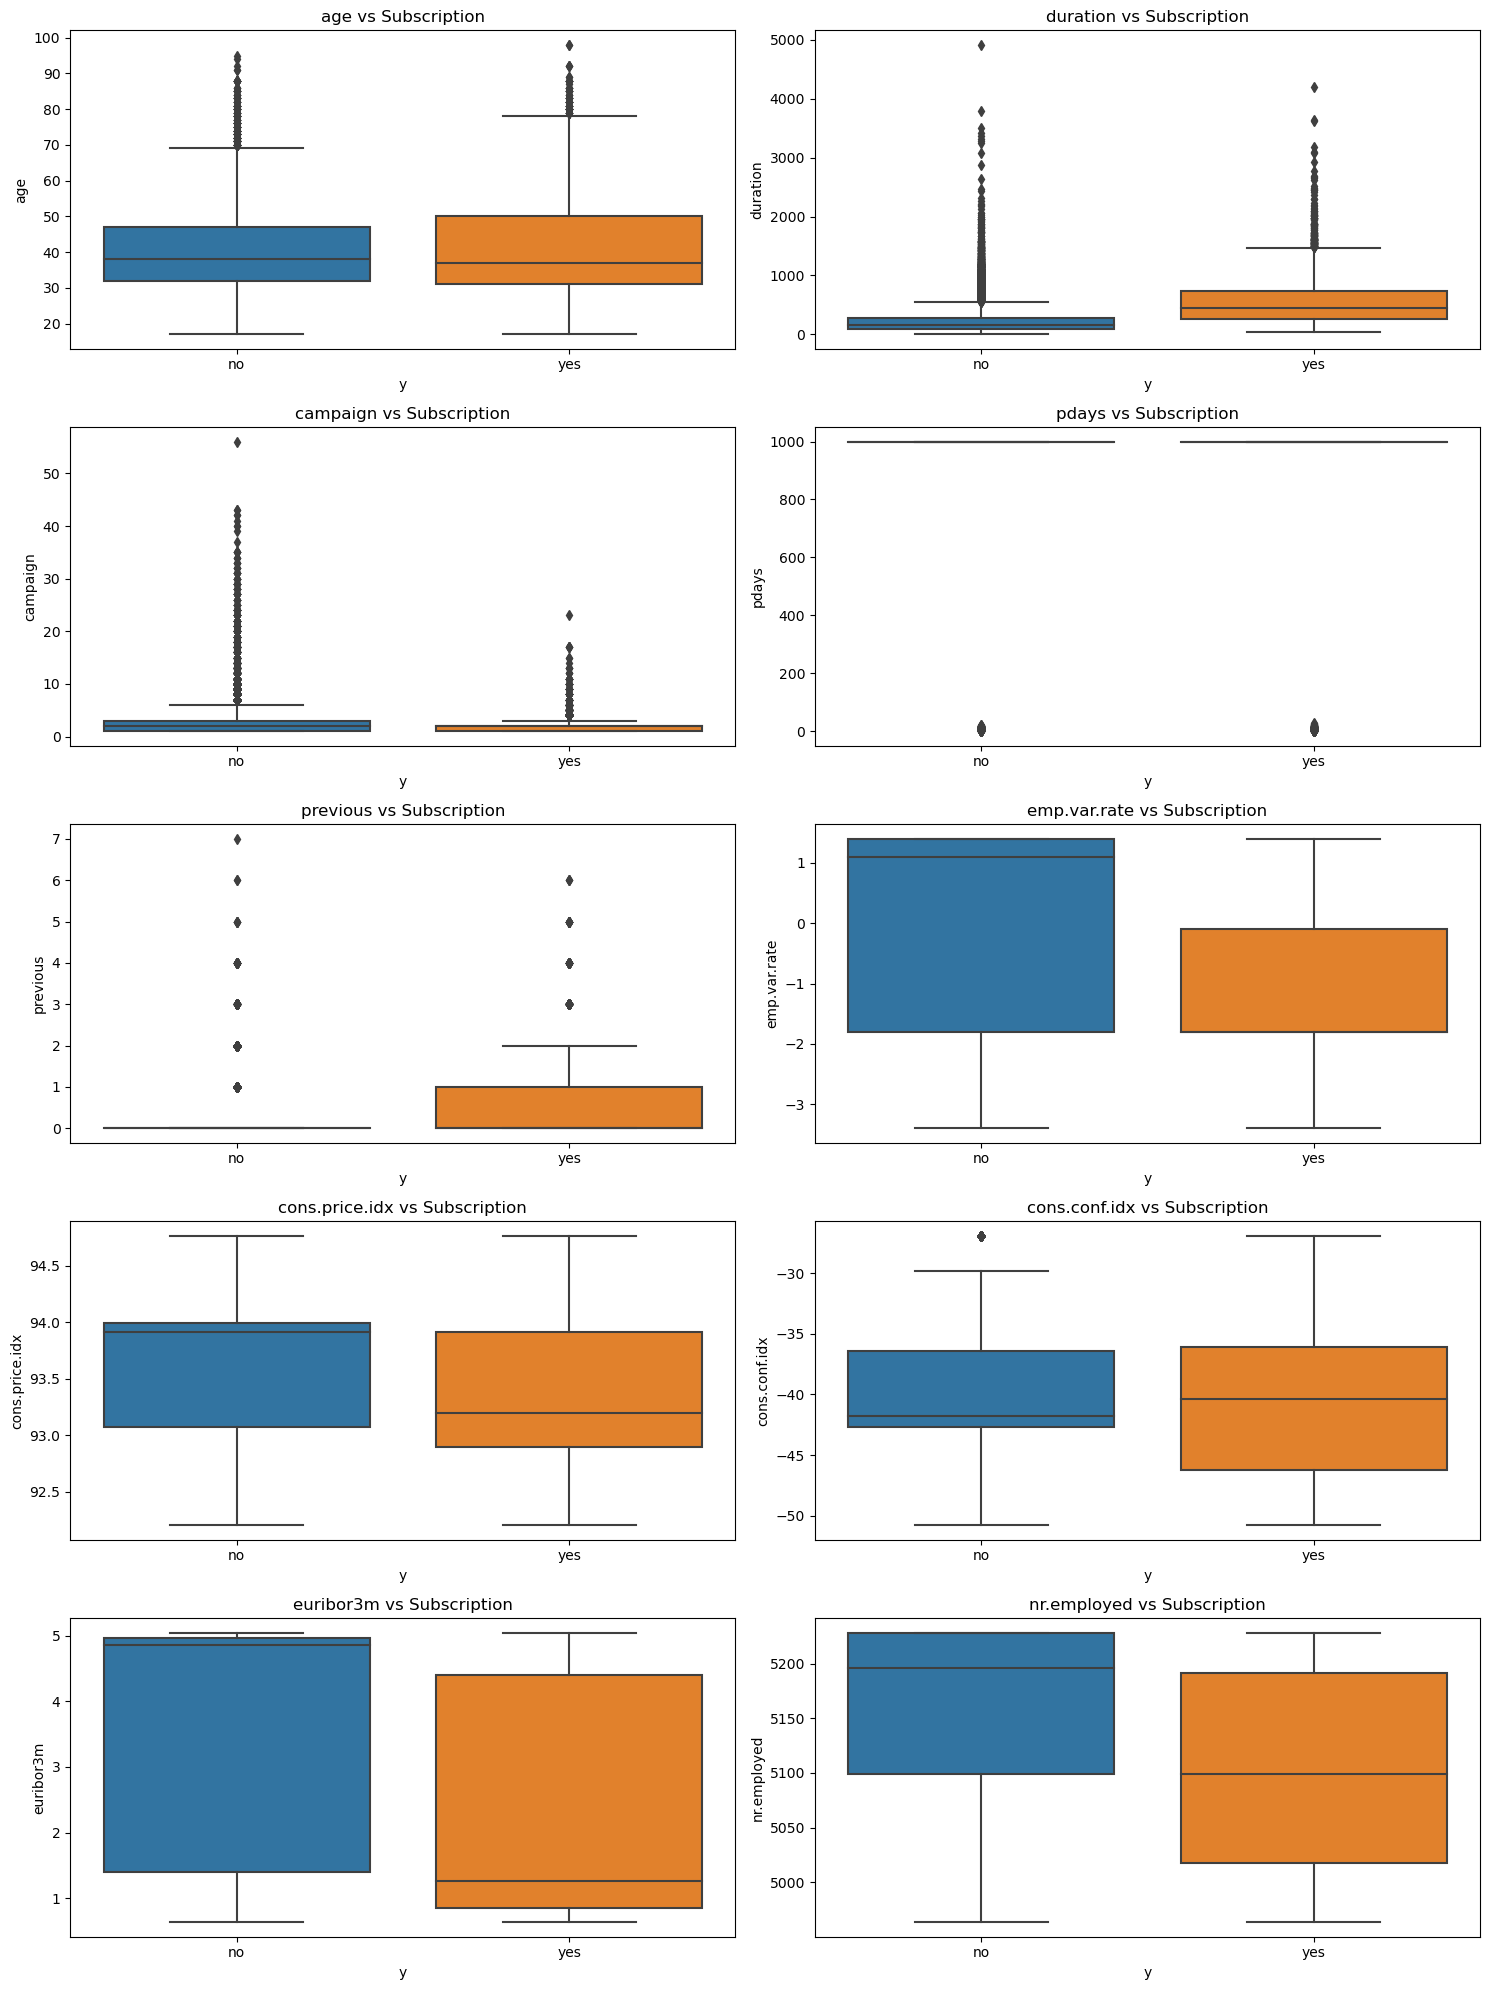

In [12]:
# Numerical vs Target
plt.figure(figsize=(15, 20))
for i, col in enumerate(num_cols):
    plt.subplot(5, 2, i+1)
    sns.boxplot(x='y', y=col, data=df)
    plt.title(f'{col} vs Subscription')
plt.tight_layout()


In [14]:
df['y']

0         no
1         no
2         no
3         no
4         no
        ... 
41183    yes
41184     no
41185     no
41186    yes
41187     no
Name: y, Length: 41188, dtype: object

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


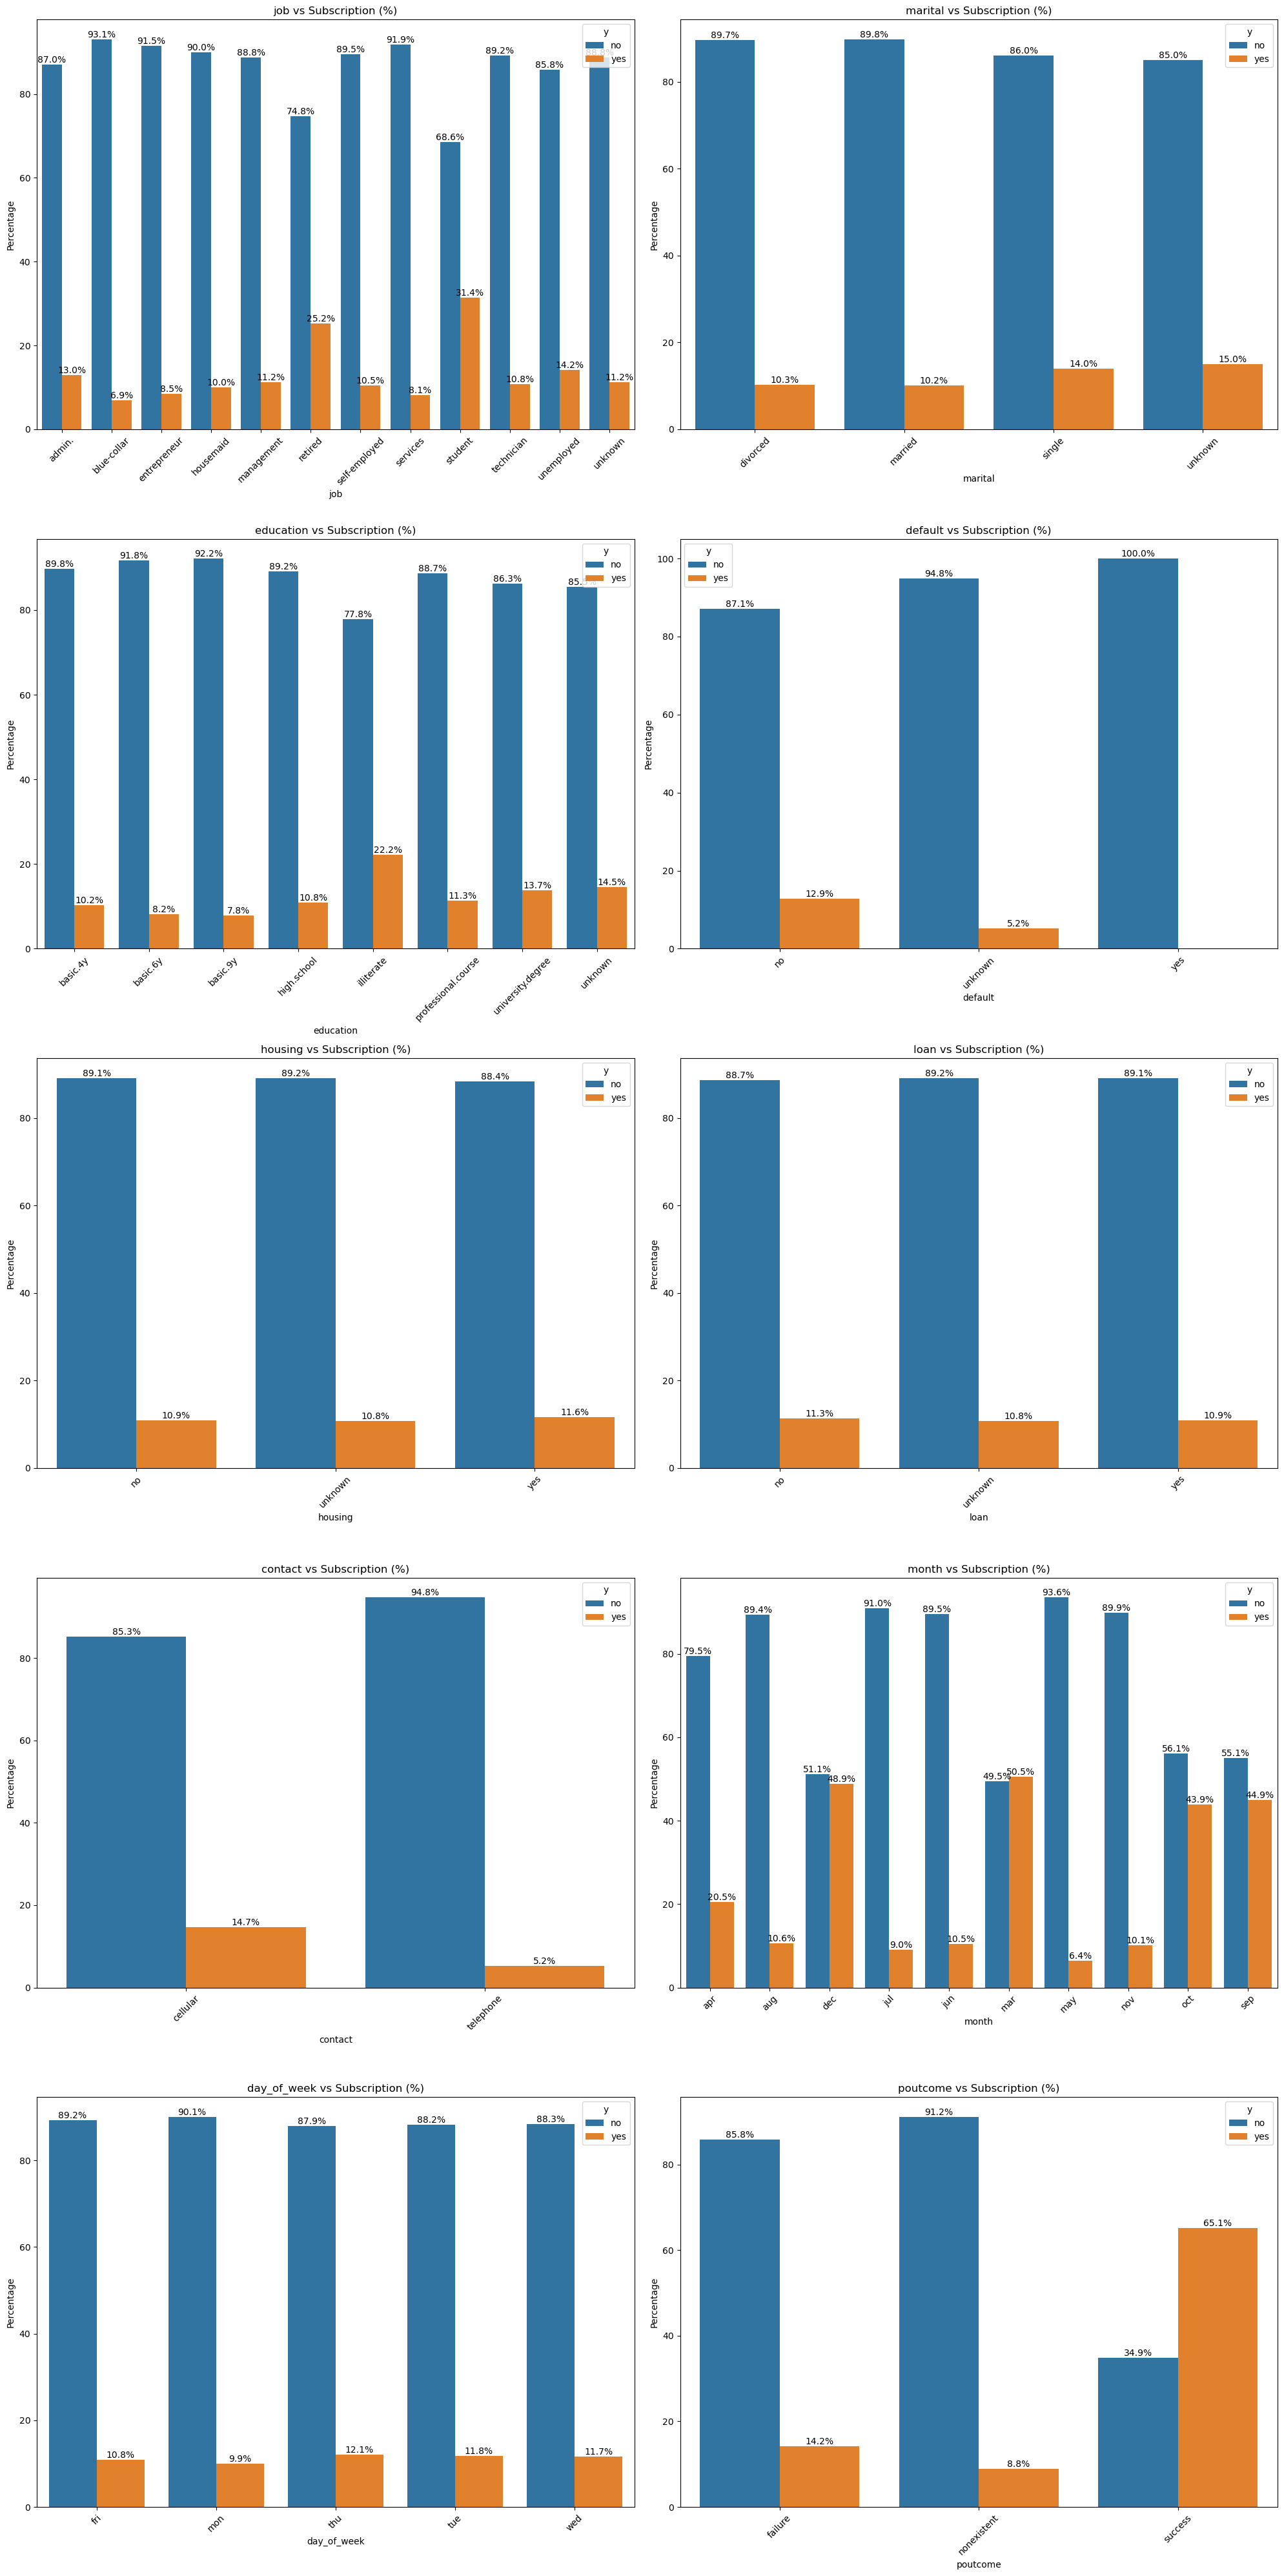

In [15]:
# Categorical vs Target
plt.figure(figsize=(20, 40))
for i, col in enumerate(categorical_cols):
    plt.subplot(5, 2, i+1)
    prop_df = (df.groupby(col)['y']
               .value_counts(normalize=True)
               .mul(100)
               .rename('percent')
               .reset_index())
    ax = sns.barplot(x=col, y='percent', hue='y', data=prop_df)
    plt.title(f'{col} vs Subscription (%)')
    plt.xticks(rotation=45)
    plt.ylabel('Percentage')
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2., height, 
                f'{height:.1f}%', ha='center', va='bottom')
plt.tight_layout()


Text(0.5, 1.0, 'Feature Correlation Matrix')

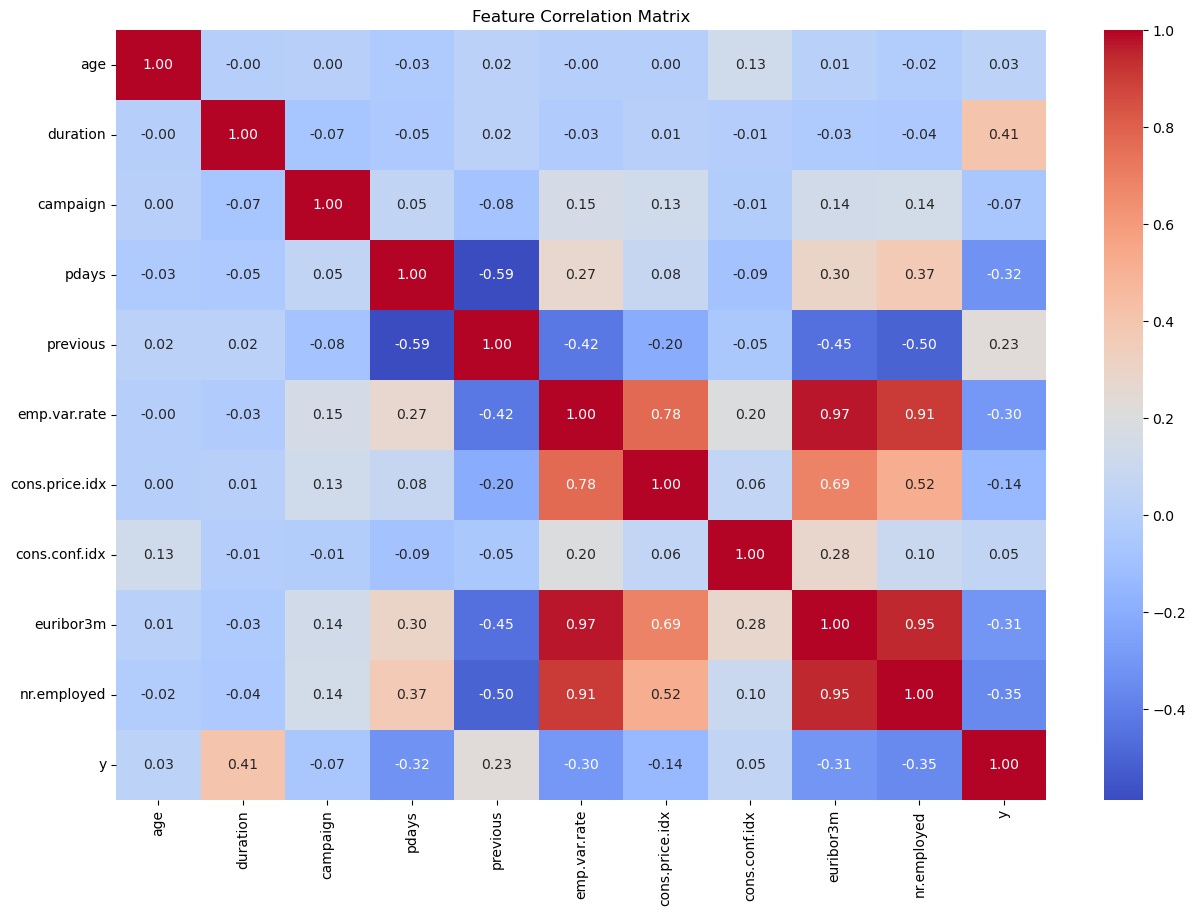

In [16]:
df['y'] = df['y'].map({'no':0, 'yes':1})
corr_matrix = df[num_cols + ['y']].corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')


In [17]:
df['y']

0        0
1        0
2        0
3        0
4        0
        ..
41183    1
41184    0
41185    0
41186    1
41187    0
Name: y, Length: 41188, dtype: int64

In [18]:
# Create new features
df['contact_ratio'] = df['campaign'] / (df['previous'] + 1)
df['success_ratio'] = df['pdays'] / (df['previous'] + 1)

# Add new features to preprocessing
num_cols += ['contact_ratio', 'success_ratio']


In [19]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,contact_ratio,success_ratio
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,1.0,999.0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,1.0,999.0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,1.0,999.0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,1.0,999.0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,1.0,999.0


In [ ]:
# df['y'] = df['y'].map({'yes': 1, 'no': 0})


In [20]:
# Split features and target
X = df.drop('y', axis=1)
y = df['y']


In [21]:
y

0        0
1        0
2        0
3        0
4        0
        ..
41183    1
41184    0
41185    0
41186    1
41187    0
Name: y, Length: 41188, dtype: int64

In [22]:
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()


In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y)


In [24]:
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Training class distribution:\n{y_train.value_counts(normalize=True)}")


Training set size: 32950 samples
Test set size: 8238 samples
Training class distribution:
y
0    0.887344
1    0.112656
Name: proportion, dtype: float64


In [25]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


In [26]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)


In [27]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_preprocessed, y_train)


In [28]:
# Feature selection with SelectKBest
k = 15  # Number of features to select
selector = SelectKBest(score_func=f_classif, k=k)
X_train_selected = selector.fit_transform(X_train_resampled, y_train_resampled)
X_test_selected = selector.transform(X_test_preprocessed)


In [29]:
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_feature_names = numerical_cols + list(ohe_feature_names)


In [30]:
# Selected feature names

mask = selector.get_support()
selected_features = [feature for bool_mask, feature in zip(mask, all_feature_names) if bool_mask]
print(f"Selected top {k} features:")
print(selected_features)


Selected top 15 features:
['duration', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'euribor3m', 'nr.employed', 'success_ratio', 'default_no', 'default_unknown', 'contact_cellular', 'contact_telephone', 'month_may', 'poutcome_nonexistent', 'poutcome_success']


In [31]:
# 12. Train Random Forest classifier
model = RandomForestClassifier( random_state=42, class_weight='balanced')

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train_selected, y_train_resampled)


print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation F1 score: {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_

# Evaluate best model on test data
y_pred = best_model.predict(X_test_selected)


print("\nModel Evaluation on Test Set:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred):.4f}")


# model.fit(X_train_selected, y_train_resampled)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters found: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation F1 score: 0.9217

Model Evaluation on Test Set:
Accuracy:  0.8864
Precision: 0.4973
Recall:    0.8028
F1 Score:  0.6142


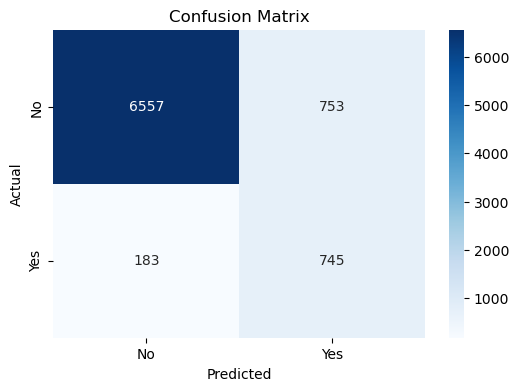


Classification Report:
                 precision    recall  f1-score   support

No Subscription       0.97      0.90      0.93      7310
   Subscription       0.50      0.80      0.61       928

       accuracy                           0.89      8238
      macro avg       0.74      0.85      0.77      8238
   weighted avg       0.92      0.89      0.90      8238



In [32]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Subscription', 'Subscription']))


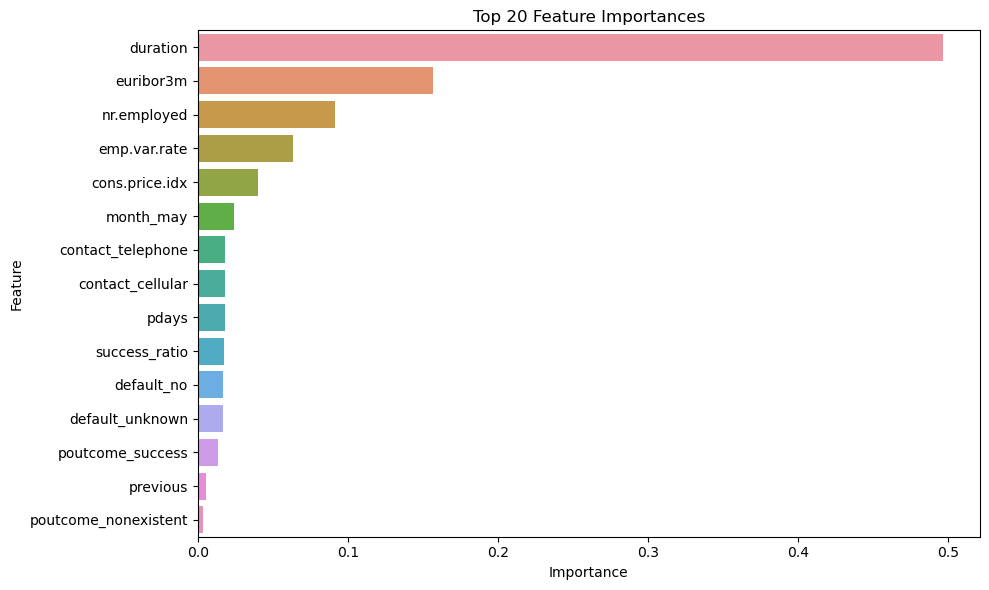

Top 10 Important Features:
              Feature  Importance
0            duration    0.496546
5           euribor3m    0.156971
6         nr.employed    0.091454
3        emp.var.rate    0.063379
4      cons.price.idx    0.040246
12          month_may    0.023915
11  contact_telephone    0.018103
10   contact_cellular    0.018043
1               pdays    0.017878
7       success_ratio    0.017595


In [33]:
importances = best_model.feature_importances_
feat_imp_df = pd.DataFrame({'Feature': selected_features, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(20))
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()

print("Top 10 Important Features:")
print(feat_imp_df.head(10))


In [34]:
# 15. Save best model and preprocessing objects
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

with open('preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

with open('selector.pkl', 'wb') as f:
    pickle.dump(selector, f)

print("Best model, preprocessor, and selector saved successfully.")


Best model, preprocessor, and selector saved successfully.
